# imports

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt

In [4]:
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('go_sales_train.sqlite')

# List all tables in the database
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables


,name
0,country
1,order_details
2,order_header
3,order_method
4,product_line
5,product_type
6,product
7,return_reason
8,returned_item
9,sales_branch


# read data

In [5]:
od_df = pd.read_sql("SELECT * FROM ORDER_DETAILS", conn)
od_df= od_df.loc[: , ['ORDER_DETAIL_CODE', 'PRODUCT_NUMBER', 'QUANTITY']]
od_df

,ORDER_DETAIL_CODE,PRODUCT_NUMBER,QUANTITY
0,47737,1,84
1,47738,1,126
2,47739,1,122
3,47740,1,122
4,47741,1,272
...,...,...,...
37752,115289,112,70
37753,115290,113,44
37754,115291,114,8
37755,115292,115,24


In [6]:
ri_df = pd.read_sql("SELECT * FROM RETURNED_ITEM", conn)
ri_df= ri_df.loc[: , ['ORDER_DETAIL_CODE', 'RETURN_REASON_CODE', 'RETURN_QUANTITY']]
ri_df

,ORDER_DETAIL_CODE,RETURN_REASON_CODE,RETURN_QUANTITY
0,84858,5,8
1,84440,2,2
2,84867,4,22
3,84873,3,20
4,84488,1,2
...,...,...,...
614,114967,1,12
615,114972,3,24
616,114983,5,66
617,115215,4,64


In [7]:
rr_df = pd.read_sql("SELECT * FROM RETURN_REASON", conn)
rr_df

,RETURN_REASON_CODE,RETURN_DESCRIPTION_EN
0,1,Defective product
1,2,Incomplete product
2,3,Wrong product ordered
3,4,Wrong product shipped
4,5,Unsatisfactory product


In [8]:
rr_dummies_dataframe = pd.get_dummies(rr_df, columns = ['RETURN_DESCRIPTION_EN'], prefix = 'reason')

rr_dummies_dataframe = pd.concat([rr_df['RETURN_REASON_CODE'], 
                                  pd.get_dummies(rr_df['RETURN_DESCRIPTION_EN'], prefix='reason')], 
                                  axis=1)
rr_dummies_dataframe

,RETURN_REASON_CODE,reason_Defective product,reason_Incomplete product,reason_Unsatisfactory product,reason_Wrong product ordered,reason_Wrong product shipped
0,1,True,False,False,False,False
1,2,False,True,False,False,False
2,3,False,False,False,True,False
3,4,False,False,False,False,True
4,5,False,False,True,False,False


# snijden

In [9]:
df = pd.merge(od_df, ri_df, on='ORDER_DETAIL_CODE', how='inner')
df = pd.merge(df, rr_dummies_dataframe, on='RETURN_REASON_CODE', how='inner')
df = df.dropna(subset=['RETURN_REASON_CODE'])
df

,ORDER_DETAIL_CODE,PRODUCT_NUMBER,QUANTITY,RETURN_REASON_CODE,RETURN_QUANTITY,reason_Defective product,reason_Incomplete product,reason_Unsatisfactory product,reason_Wrong product ordered,reason_Wrong product shipped
0,47743,1,104,3,104,False,False,False,True,False
1,47755,2,44,2,4,False,True,False,False,False
2,47767,4,84,2,6,False,True,False,False,False
3,47776,5,52,3,52,False,False,False,True,False
4,47783,6,20,4,20,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
614,115101,13,106,2,10,False,True,False,False,False
615,115142,30,94,1,10,True,False,False,False,False
616,115144,31,240,2,8,False,True,False,False,False
617,115189,60,82,1,4,True,False,False,False,False


In [10]:
X = df.drop('RETURN_REASON_CODE', axis = 1)
y = df.loc[:, ['RETURN_REASON_CODE']]
X

,ORDER_DETAIL_CODE,PRODUCT_NUMBER,QUANTITY,RETURN_QUANTITY,reason_Defective product,reason_Incomplete product,reason_Unsatisfactory product,reason_Wrong product ordered,reason_Wrong product shipped
0,47743,1,104,104,False,False,False,True,False
1,47755,2,44,4,False,True,False,False,False
2,47767,4,84,6,False,True,False,False,False
3,47776,5,52,52,False,False,False,True,False
4,47783,6,20,20,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
614,115101,13,106,10,False,True,False,False,False
615,115142,30,94,10,True,False,False,False,False
616,115144,31,240,8,False,True,False,False,False
617,115189,60,82,4,True,False,False,False,False


# train test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.15,
    random_state=42
)

In [12]:
list(X.columns)

['ORDER_DETAIL_CODE',
 'PRODUCT_NUMBER',
 'QUANTITY',
 'RETURN_QUANTITY',
 'reason_Defective product',
 'reason_Incomplete product',
 'reason_Unsatisfactory product',
 'reason_Wrong product ordered',
 'reason_Wrong product shipped']

# decision tree

### max depth 2

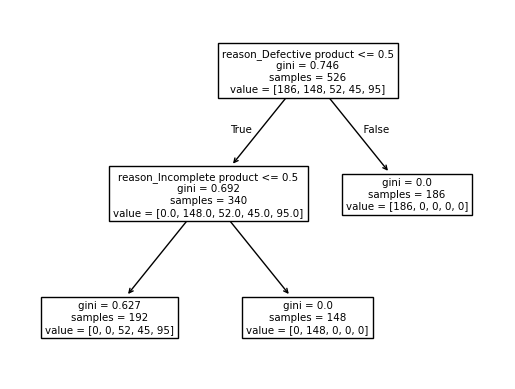

In [13]:
dectree = DecisionTreeClassifier(max_depth = 2)
dectree = dectree.fit(X_train, y_train)
tree.plot_tree(dectree, feature_names = X.columns)
plt.show()

## df set

In [14]:
predicted_df = pd.DataFrame(dectree.predict(X_test))
predicted_df = predicted_df.rename(columns = {0 : 'predicted_return_reason_code'})
model_results_frame = pd.concat([y_test.reset_index()['RETURN_REASON_CODE'], predicted_df], axis = 1)
model_results_frame

,RETURN_REASON_CODE,predicted_return_reason_code
0,3,5
1,3,5
2,1,1
3,1,1
4,1,1
...,...,...
88,2,2
89,1,1
90,1,1
91,1,1


## confusion matrix

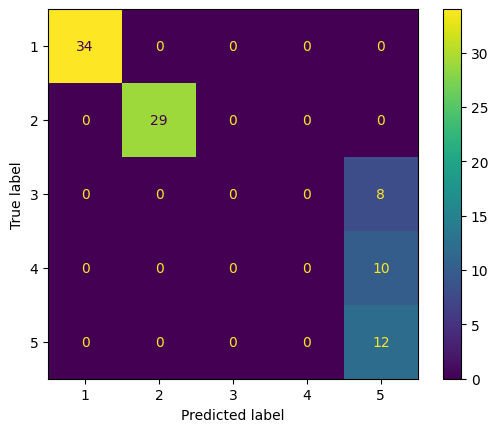

In [16]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURN_REASON_CODE'], model_results_frame['predicted_return_reason_code'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5])

cm_display.plot()
plt.show()

In [17]:
metrics.accuracy_score(model_results_frame['RETURN_REASON_CODE'], model_results_frame['predicted_return_reason_code'])

0.8064516129032258

## max depth 3

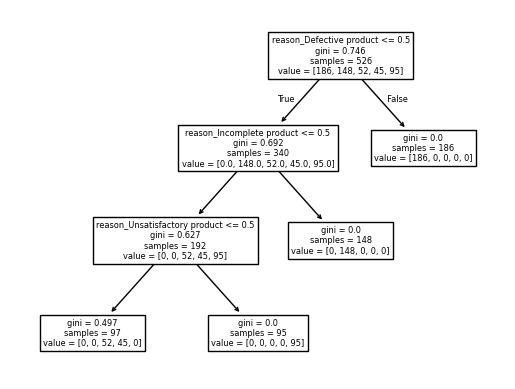

In [18]:
dectree = DecisionTreeClassifier(max_depth = 3)
dectree = dectree.fit(X_train, y_train)
tree.plot_tree(dectree, feature_names = X.columns)
plt.show()

In [19]:
predicted_df = pd.DataFrame(dectree.predict(X_test))
predicted_df = predicted_df.rename(columns = {0 : 'Predicted_return_reason_code'})
model_results_frame = pd.concat([y_test.reset_index()['RETURN_REASON_CODE'], predicted_df], axis = 1)
model_results_frame

,RETURN_REASON_CODE,Predicted_return_reason_code
0,3,3
1,3,3
2,1,1
3,1,1
4,1,1
...,...,...
88,2,2
89,1,1
90,1,1
91,1,1


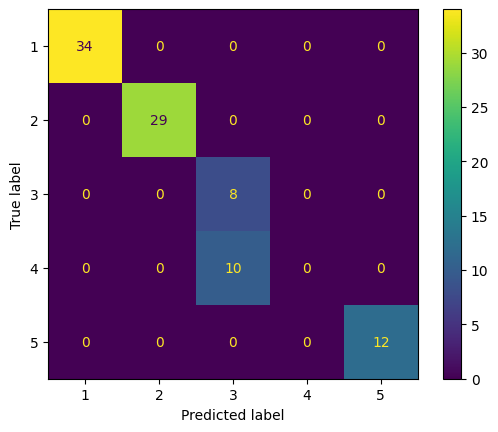

In [22]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_return_reason_code'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5])

cm_display.plot()
plt.show()

In [23]:
metrics.accuracy_score(model_results_frame['RETURN_REASON_CODE'], model_results_frame['Predicted_return_reason_code'])

0.8924731182795699

## geen max depth

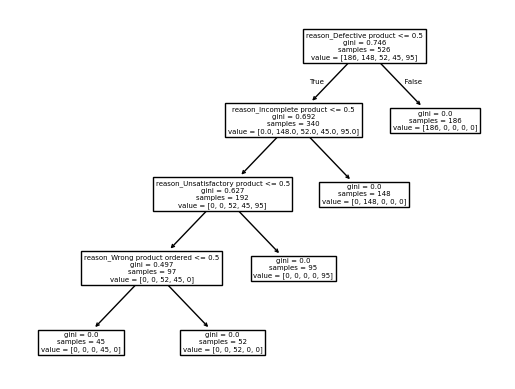

In [24]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)
tree.plot_tree(dtree, feature_names = X.columns)
plt.show()

In [25]:
predicted_df = pd.DataFrame(dtree.predict(X_test))
predicted_df = predicted_df.rename(columns = {0 : 'predic_return_reason_code'})
model_results_frame = pd.concat([y_test.reset_index()['RETURN_REASON_CODE'], predicted_df], axis = 1)
model_results_frame

,RETURN_REASON_CODE,predic_return_reason_code
0,3,3
1,3,3
2,1,1
3,1,1
4,1,1
...,...,...
88,2,2
89,1,1
90,1,1
91,1,1


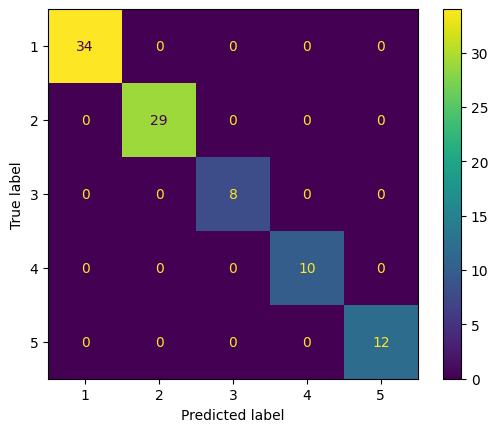

In [29]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['RETURN_REASON_CODE'], model_results_frame['predic_return_reason_code'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4, 5])

cm_display.plot()
plt.show()

In [30]:
metrics.accuracy_score(model_results_frame['RETURN_REASON_CODE'], model_results_frame['predic_return_reason_code'])

1.0